# SLERP Visualization on the Unit Sphere

This notebook demonstrates Spherical Linear Interpolation (SLERP) between quaternions with an animated visualization showing the interpolation path on the unit sphere.

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

from fastquat import Quaternion

# Configure matplotlib for better rendering
plt.rcParams['figure.dpi'] = 100
plt.rcParams['animation.html'] = 'html5'

## Setup: Define Quaternions and Test Vector

We'll interpolate between two quaternions that represent significantly different rotations to make the arc clearly visible.

In [2]:
# Define two quaternions with a large angular separation for a visible arc
# q1: Identity (no rotation)
q1 = Quaternion.ones()

# q2: 120 degree rotation around axis (1, 1, 1) for a large, visible arc
axis = jnp.array([1.0, 1.0, 1.0])
axis = axis / jnp.linalg.norm(axis)  # Normalize
angle = jnp.pi * 2 / 3  # 120 degrees

q2 = Quaternion(
    jnp.cos(angle / 2),
    axis[0] * jnp.sin(angle / 2),
    axis[1] * jnp.sin(angle / 2),
    axis[2] * jnp.sin(angle / 2),
)

print(f'Start quaternion q1: {q1}')
print(f'End quaternion q2: {q2}')
print(f'Dot product: {jnp.sum(q1.wxyz * q2.wxyz):.4f}')
print(f'Angular separation: {2 * jnp.arccos(jnp.abs(jnp.sum(q1.wxyz * q2.wxyz))):.2f} radians')

Start quaternion q1: 1.0 + 0.0i + 0.0j + 0.0k
End quaternion q2: 0.4999999701976776 + 0.5i + 0.5j + 0.5k
Dot product: 0.5000
Angular separation: 2.09 radians


## Generate SLERP Interpolation

Create a smooth interpolation between the quaternions and apply them to a test vector.

In [3]:
# Generate interpolation parameters for smooth animation
n_frames = 50
t_values = jnp.linspace(0, 1, n_frames)

# SLERP interpolation
slerp_quaternions = q1.slerp(q2, t_values)

# Test vector to rotate (unit vector along x-axis)
test_vector = jnp.array([jnp.sqrt(2), -jnp.sqrt(2), 0.0])
test_vector = jnp.array([1.0, 0.0, 0.0])

# Apply rotations to test vector
slerp_rotated = slerp_quaternions.rotate_vector(test_vector)

print(f'Generated {len(slerp_rotated)} frames for animation')
print(f'All quaternions normalized: {jnp.allclose(slerp_quaternions.norm(), 1.0)}')

Generated 50 frames for animation
All quaternions normalized: True


## Display

Plot showing the complete SLERP path.

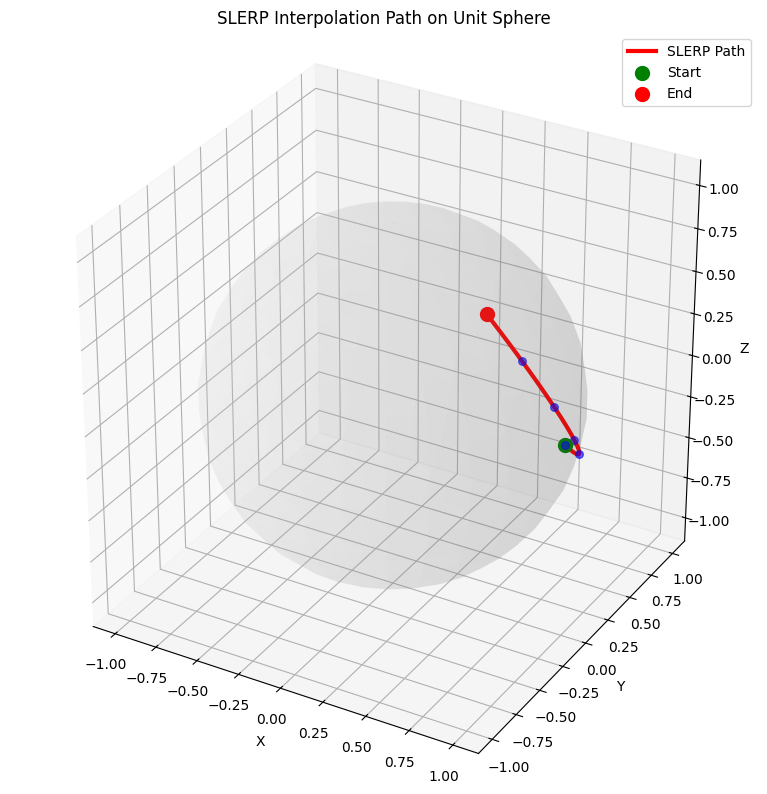

In [4]:
# Create static visualization showing the complete path
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw unit sphere
u = np.linspace(0, 2 * np.pi, 30)
v = np.linspace(0, np.pi, 20)
sphere_x = np.outer(np.cos(u), np.sin(v))
sphere_y = np.outer(np.sin(u), np.sin(v))
sphere_z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(sphere_x, sphere_y, sphere_z, alpha=0.1, color='lightgray')

# Plot SLERP path as a curve
ax.plot(
    slerp_rotated[:, 0],
    slerp_rotated[:, 1],
    slerp_rotated[:, 2],
    'r-',
    linewidth=3,
    label='SLERP Path',
)

# Mark start and end points
ax.scatter(*slerp_rotated[0], color='green', s=100, label='Start', zorder=5)
ax.scatter(*slerp_rotated[-1], color='red', s=100, label='End', zorder=5)

# Add some intermediate points
for i in range(0, len(slerp_rotated), 10):
    ax.scatter(*slerp_rotated[i], color='blue', s=30, alpha=0.6, zorder=4)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('SLERP Interpolation Path on Unit Sphere')
ax.legend()
ax.set_box_aspect([1, 1, 1])

plt.tight_layout()
plt.savefig('slerp_path_static.png', dpi=150, bbox_inches='tight')
plt.show()

## Create Animated Visualization

Now create an animation showing the interpolation progressing along the arc.

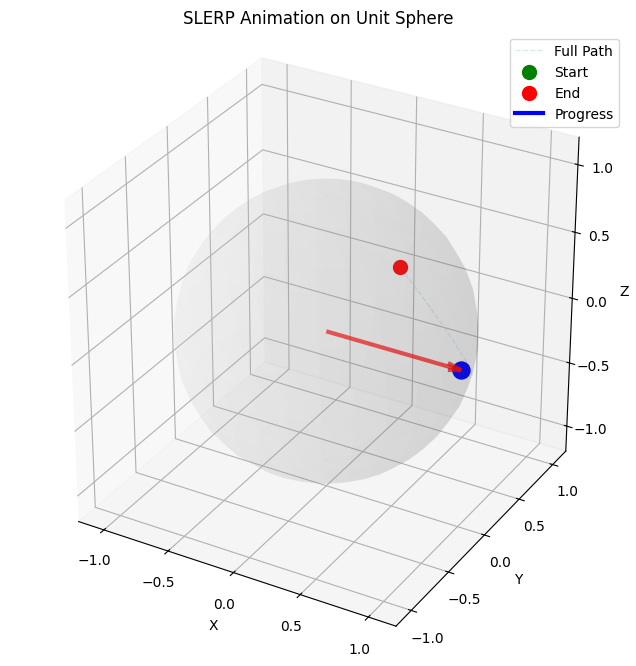

In [12]:
# Create animated visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Draw unit sphere (static)
ax.plot_surface(sphere_x, sphere_y, sphere_z, alpha=0.1, color='lightgray')

# Plot the complete path in light color
ax.plot(
    slerp_rotated[:, 0],
    slerp_rotated[:, 1],
    slerp_rotated[:, 2],
    '--',
    color='lightblue',
    linewidth=1,
    alpha=0.5,
    label='Full Path',
)

# Start and end points
ax.scatter(*slerp_rotated[0], color='green', s=100, label='Start', zorder=5)
ax.scatter(*slerp_rotated[-1], color='red', s=100, label='End', zorder=5)

# Initialize animated elements
current_point = ax.scatter([], [], [], color='blue', s=150, zorder=6)
(progress_line,) = ax.plot([], [], [], 'b-', linewidth=3, label='Progress')

# Initialize vector arrow variable
vector_arrow = None

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('SLERP Animation on Unit Sphere')
ax.legend()
ax.set_box_aspect([1, 1, 1])

# Set fixed view limits
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_zlim([-1.2, 1.2])


def animate(frame):
    global vector_arrow

    # Update current point
    current_pos = slerp_rotated[frame]
    current_point._offsets3d = ([current_pos[0]], [current_pos[1]], [current_pos[2]])

    # Update progress line (path so far)
    progress_line.set_data_3d(
        slerp_rotated[: frame + 1, 0], slerp_rotated[: frame + 1, 1], slerp_rotated[: frame + 1, 2]
    )

    # Update vector arrow from origin to current point
    # Remove previous arrow if it exists
    if vector_arrow is not None:
        vector_arrow.remove()

    # Create new arrow
    vector_arrow = ax.quiver(
        0,
        0,
        0,
        current_pos[0],
        current_pos[1],
        current_pos[2],
        color='red',
        arrow_length_ratio=0.1,
        linewidth=3,
        alpha=0.7,
    )

    return current_point, progress_line


# Create animation
anim = FuncAnimation(fig, animate, frames=n_frames, interval=100, blit=False, repeat=True)
HTML(anim.to_jshtml())

## Key Properties Demonstrated

This animation demonstrates several key properties of SLERP:

1. **Constant Angular Velocity**: The interpolation moves at constant angular speed along the arc
2. **Shortest Path**: SLERP automatically takes the shortest arc between quaternions
3. **Normalization Preservation**: All interpolated quaternions remain perfectly normalized
4. **Smooth Interpolation**: The path is perfectly smooth with no discontinuities

The red vector shows how the rotation is applied to a test vector, creating a smooth arc on the unit sphere. This makes SLERP ideal for applications like:

- 3D animation and camera controls
- Robotics motion planning
- Scientific visualization
- Game engine rotation interpolation